# Phase 2: Baseline Model - XGBoost Classifier
# NASA Turbofan Engine Degradation Dataset

**Objective:** Train XGBoost baseline classifier for failure prediction

**Goals:**
- Load engineered features from Phase 2
- Time-based train/val/test split (70/15/15)
- Handle class imbalance (SMOTE + class weights)
- Feature selection based on importance
- Hyperparameter tuning with Optuna (50 trials)
- MLflow experiment tracking

**Target Metrics:**
- **F2 Score > 0.75** (emphasizes recall)
- **Precision > 0.65** (minimize false alarms)
- **Recall > 0.85** (catch failures early)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    fbeta_score, precision_score, recall_score,
    roc_auc_score, roc_curve, precision_recall_curve
)
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import optuna

# MLflow
import mlflow
import mlflow.xgboost

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. Load Engineered Features

In [2]:
# Load engineered features
data_path = Path('../data/processed/train_features_FD001.csv')
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"Number of engines: {df['unit_id'].nunique()}")
print(f"\nClass distribution:")
print(df['failure_soon'].value_counts())
print(f"\nImbalance ratio: {(df['failure_soon'] == 0).sum() / (df['failure_soon'] == 1).sum():.2f}:1")

df.head()

Dataset shape: (20631, 128)
Number of engines: 100

Class distribution:
failure_soon
0    17531
1     3100
Name: count, dtype: int64

Imbalance ratio: 5.66:1


,unit_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL,failure_soon,sensor_11_roll_mean_5,sensor_11_roll_std_5,sensor_11_roll_max_5,sensor_11_roll_min_5,sensor_11_roll_mean_10,sensor_11_roll_std_10,sensor_11_roll_max_10,sensor_11_roll_min_10,sensor_11_roll_mean_25,sensor_11_roll_std_25,sensor_11_roll_max_25,sensor_11_roll_min_25,sensor_4_roll_mean_5,sensor_4_roll_std_5,sensor_4_roll_max_5,sensor_4_roll_min_5,sensor_4_roll_mean_10,sensor_4_roll_std_10,sensor_4_roll_max_10,sensor_4_roll_min_10,sensor_4_roll_mean_25,sensor_4_roll_std_25,sensor_4_roll_max_25,sensor_4_roll_min_25,sensor_12_roll_mean_5,sensor_12_roll_std_5,sensor_12_roll_max_5,sensor_12_roll_min_5,sensor_12_roll_mean_10,sensor_12_roll_std_10,sensor_12_roll_max_10,sensor_12_roll_min_10,sensor_12_roll_mean_25,sensor_12_roll_std_25,sensor_12_roll_max_25,sensor_12_roll_min_25,sensor_7_roll_mean_5,sensor_7_roll_std_5,sensor_7_roll_max_5,sensor_7_roll_min_5,sensor_7_roll_mean_10,sensor_7_roll_std_10,sensor_7_roll_max_10,sensor_7_roll_min_10,sensor_7_roll_mean_25,sensor_7_roll_std_25,sensor_7_roll_max_25,sensor_7_roll_min_25,sensor_15_roll_mean_5,sensor_15_roll_std_5,sensor_15_roll_max_5,sensor_15_roll_min_5,sensor_15_roll_mean_10,sensor_15_roll_std_10,sensor_15_roll_max_10,sensor_15_roll_min_10,sensor_15_roll_mean_25,sensor_15_roll_std_25,sensor_15_roll_max_25,sensor_15_roll_min_25,sensor_11_lag_1,sensor_11_lag_3,sensor_11_lag_5,sensor_4_lag_1,sensor_4_lag_3,sensor_4_lag_5,sensor_12_lag_1,sensor_12_lag_3,sensor_12_lag_5,sensor_7_lag_1,sensor_7_lag_3,sensor_7_lag_5,sensor_15_lag_1,sensor_15_lag_3,sensor_15_lag_5,sensor_11_diff_1,sensor_11_diff_2,sensor_11_cumsum,sensor_4_diff_1,sensor_4_diff_2,sensor_4_cumsum,sensor_12_diff_1,sensor_12_diff_2,sensor_12_cumsum,sensor_7_diff_1,sensor_7_diff_2,sensor_7_cumsum,sensor_15_diff_1,sensor_15_diff_2,sensor_15_cumsum,cycles_normalized,temp_pressure_ratio,vibration_temp_product,sensor_2_zscore,sensor_3_zscore,sensor_11_zscore,op_setting_1_diff,op_setting_2_diff,op_setting_3_diff,degradation_stage
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,47.470,0.000000,47.47,47.47,47.470,0.000000,47.47,47.47,47.470,0.000000,47.47,47.47,1400.600000,0.000000,1400.60,1400.6,1400.600000,0.000000,1400.60,1400.6,1400.600000,0.000000,1400.60,1400.6,521.660,0.000000,521.66,521.66,521.660,0.000000,521.66,521.66,521.660,0.000000,521.66,521.66,554.360000,0.000000,554.36,554.36,554.360000,0.000000,554.36,554.36,554.360000,0.000000,554.36,554.36,8.419500,0.000000,8.4195,8.4195,8.419500,0.000000,8.4195,8.4195,8.419500,0.000000,8.4195,8.4195,47.47,47.47,47.47,1400.60,1400.60,1400.6,521.66,521.66,521.66,554.36,554.36,554.36,8.4195,8.4195,8.4195,0.00,0.00,47.47,0.00,0.00,1400.60,0.00,0.00,521.66,0.00,0.00,554.36,0.0000,0.0000,8.4195,0.000000,0.403737,30467.1954,-1.645538,0.037237,-0.164200,0.0000,0.0000,0.0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,47.480,0.014142,47.49,47.47,47.480,0.014142,47.49,47.47,47.480,0.014142,47.49,47.47,1401.870000,1.796051,1403.14,1400.6,1401.870000,1.796051,1403.14,1400.6,1401.870000,1.796051,1403.14,1400.6,521.970,0.438406,522.28,521.66,521.970,0.438406,522.28,521.66,521.970,0.438406,522.28,521.66,554.055000,0.431335,554.36,553.75,554.055000,0.431335,554.36,553.75,554.055000,0.431335,554.36,553.75,8.425650,0.008697,8.4318,8.4195,8.425650,0.008697,8.4318,8.4195,8.425650,0.008697,8.4318,8.4195,47.47,47.47,47.47,1400.60,1400.60,1400.6,521.66,521.66,521.66,554.36,554.36,554.36,8.4195,8.4195,8.4195,0.02,0.00,94.96,2.54,0.00,2803.74,0.62,0.00,1043.94,-0.61,0.00,1108.11,0.0123,0.0000,1

In [3]:
# Load feature metadata
with open('../data/processed/feature_metadata.json', 'r') as f:
    metadata = json.load(f)

print(f"Total features: {metadata['total_features']}")
print(f"Engineered features: {metadata['engineered_features']}")
print(f"\nTop 5 features by correlation:")
top_features = list(metadata['top_15_correlations'].keys())[:5]
for i, feat in enumerate(top_features, 1):
    print(f"  {i}. {feat}: {metadata['top_15_correlations'][feat]:.3f}")

Total features: 128
Engineered features: 100

Top 5 features by correlation:
  1. sensor_11_zscore: 0.736
  2. sensor_11_roll_mean_5: 0.697
  3. sensor_4_roll_mean_5: 0.696
  4. sensor_15_roll_mean_10: 0.695
  5. sensor_15_roll_mean_5: 0.693


## 2. Feature Selection & Preparation

In [4]:
# Select features for modeling
# Exclude: unit_id (identifier), cycle (temporal), RUL (target leakage)
exclude_cols = ['unit_id', 'cycle', 'RUL', 'failure_soon']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Features for modeling: {len(feature_cols)}")
print(f"\nSample features: {feature_cols[:10]}")

# Prepare X and y
X = df[feature_cols]
y = df['failure_soon']

print(f"\n✅ Feature matrix shape: {X.shape}")
print(f"✅ Target shape: {y.shape}")

Features for modeling: 124

Sample features: ['op_setting_1', 'op_setting_2', 'op_setting_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7']

✅ Feature matrix shape: (20631, 124)
✅ Target shape: (20631,)


## 3. Time-Based Train/Val/Test Split

Split engines (not rows) to prevent data leakage - ensures production-realistic evaluation

In [5]:
# Get unique engines
engines = df['unit_id'].unique()
n_engines = len(engines)

# Split engines: 70% train, 15% val, 15% test
train_engines = engines[:int(0.7 * n_engines)]
val_engines = engines[int(0.7 * n_engines):int(0.85 * n_engines)]
test_engines = engines[int(0.85 * n_engines):]

print(f"Total engines: {n_engines}")
print(f"Train engines: {len(train_engines)} ({len(train_engines)/n_engines*100:.1f}%)")
print(f"Val engines: {len(val_engines)} ({len(val_engines)/n_engines*100:.1f}%)")
print(f"Test engines: {len(test_engines)} ({len(test_engines)/n_engines*100:.1f}%)")

# Create splits
train_mask = df['unit_id'].isin(train_engines)
val_mask = df['unit_id'].isin(val_engines)
test_mask = df['unit_id'].isin(test_engines)

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"\nTrain samples: {len(X_train)} (Class 1: {y_train.sum()})")
print(f"Val samples: {len(X_val)} (Class 1: {y_val.sum()})")
print(f"Test samples: {len(X_test)} (Class 1: {y_test.sum()})")

Total engines: 100
Train engines: 70 (70.0%)
Val engines: 15 (15.0%)
Test engines: 15 (15.0%)

Train samples: 14130 (Class 1: 2170)
Val samples: 3210 (Class 1: 465)
Test samples: 3291 (Class 1: 465)


## 4. Feature Scaling

In [6]:
# Standardize features (fit on train only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled (StandardScaler)")
print(f"\nTrain mean: {X_train_scaled.mean():.4f}, std: {X_train_scaled.std():.4f}")
print(f"Val mean: {X_val_scaled.mean():.4f}, std: {X_val_scaled.std():.4f}")
print(f"Test mean: {X_test_scaled.mean():.4f}, std: {X_test_scaled.std():.4f}")

✅ Features scaled (StandardScaler)

Train mean: -0.0000, std: 0.9672
Val mean: 0.0031, std: 0.9811
Test mean: 0.0026, std: 0.9530


## 5. Handle Class Imbalance - SMOTE

In [7]:
# Apply SMOTE to balance training data
print("Before SMOTE:")
print(f"  Class 0: {(y_train == 0).sum()}")
print(f"  Class 1: {(y_train == 1).sum()}")
print(f"  Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}:1")

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\nAfter SMOTE:")
print(f"  Class 0: {(y_train_balanced == 0).sum()}")
print(f"  Class 1: {(y_train_balanced == 1).sum()}")
print(f"  Ratio: {(y_train_balanced == 0).sum() / (y_train_balanced == 1).sum():.2f}:1")
print(f"\n✅ SMOTE applied - Training data balanced")

Before SMOTE:
  Class 0: 11960
  Class 1: 2170
  Ratio: 5.51:1

After SMOTE:
  Class 0: 11960
  Class 1: 11960
  Ratio: 1.00:1

✅ SMOTE applied - Training data balanced


## 6. Baseline XGBoost Model

In [8]:
# Train baseline XGBoost
print("Training baseline XGBoost...")

xgb_baseline = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    tree_method='hist',  # CPU-optimized
    eval_metric='logloss'
)

xgb_baseline.fit(
    X_train_balanced, 
    y_train_balanced,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False
)

print("✅ Baseline model trained")

Training baseline XGBoost...
✅ Baseline model trained


In [9]:
# Evaluate baseline
y_val_pred = xgb_baseline.predict(X_val_scaled)
y_val_proba = xgb_baseline.predict_proba(X_val_scaled)[:, 1]

f2 = fbeta_score(y_val, y_val_pred, beta=2)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_proba)

print("="*60)
print("BASELINE MODEL PERFORMANCE (Validation Set)")
print("="*60)
print(f"\nF2 Score:   {f2:.4f} {'✅' if f2 > 0.75 else '❌ (Target: >0.75)'}")
print(f"Precision:  {precision:.4f} {'✅' if precision > 0.65 else '❌ (Target: >0.65)'}")
print(f"Recall:     {recall:.4f} {'✅' if recall > 0.85 else '❌ (Target: >0.85)'}")
print(f"ROC-AUC:    {roc_auc:.4f}")

print(f"\n{classification_report(y_val, y_val_pred, target_names=['Normal', 'Failure Soon'])}")

BASELINE MODEL PERFORMANCE (Validation Set)

F2 Score:   0.9979 ✅
Precision:  0.9894 ✅
Recall:     1.0000 ✅
ROC-AUC:    1.0000

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      2745
Failure Soon       0.99      1.00      0.99       465

    accuracy                           1.00      3210
   macro avg       0.99      1.00      1.00      3210
weighted avg       1.00      1.00      1.00      3210



## 7. Confusion Matrix Visualization

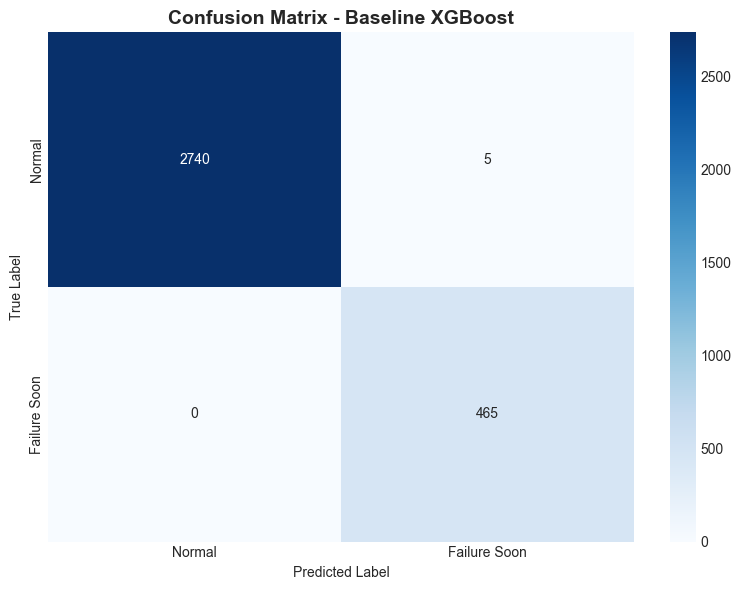

True Negatives: 2740
False Positives: 5
False Negatives: 0 ⚠️ (Missed failures)
True Positives: 465


In [10]:
# Plot confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Failure Soon'],
            yticklabels=['Normal', 'Failure Soon'])
plt.title('Confusion Matrix - Baseline XGBoost', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]} ⚠️ (Missed failures)")
print(f"True Positives: {cm[1,1]}")

## 8. Feature Importance Analysis

Top 20 Most Important Features:
                    feature  importance
114       cycles_normalized    0.499618
67     sensor_7_roll_min_10    0.058240
104         sensor_4_cumsum    0.052833
82    sensor_15_roll_max_25    0.046658
107        sensor_12_cumsum    0.046633
101        sensor_11_cumsum    0.027577
52   sensor_12_roll_mean_10    0.017077
75     sensor_15_roll_min_5    0.015740
32   sensor_11_roll_mean_25    0.014484
110         sensor_7_cumsum    0.012537
11                 sensor_9    0.011932
108         sensor_7_diff_1    0.011413
61      sensor_7_roll_std_5    0.009653
119        sensor_11_zscore    0.009603
64    sensor_7_roll_mean_10    0.008417
113        sensor_15_cumsum    0.007671
76   sensor_15_roll_mean_10    0.006327
121       op_setting_2_diff    0.006321
24    sensor_11_roll_mean_5    0.004771
33    sensor_11_roll_std_25    0.003997


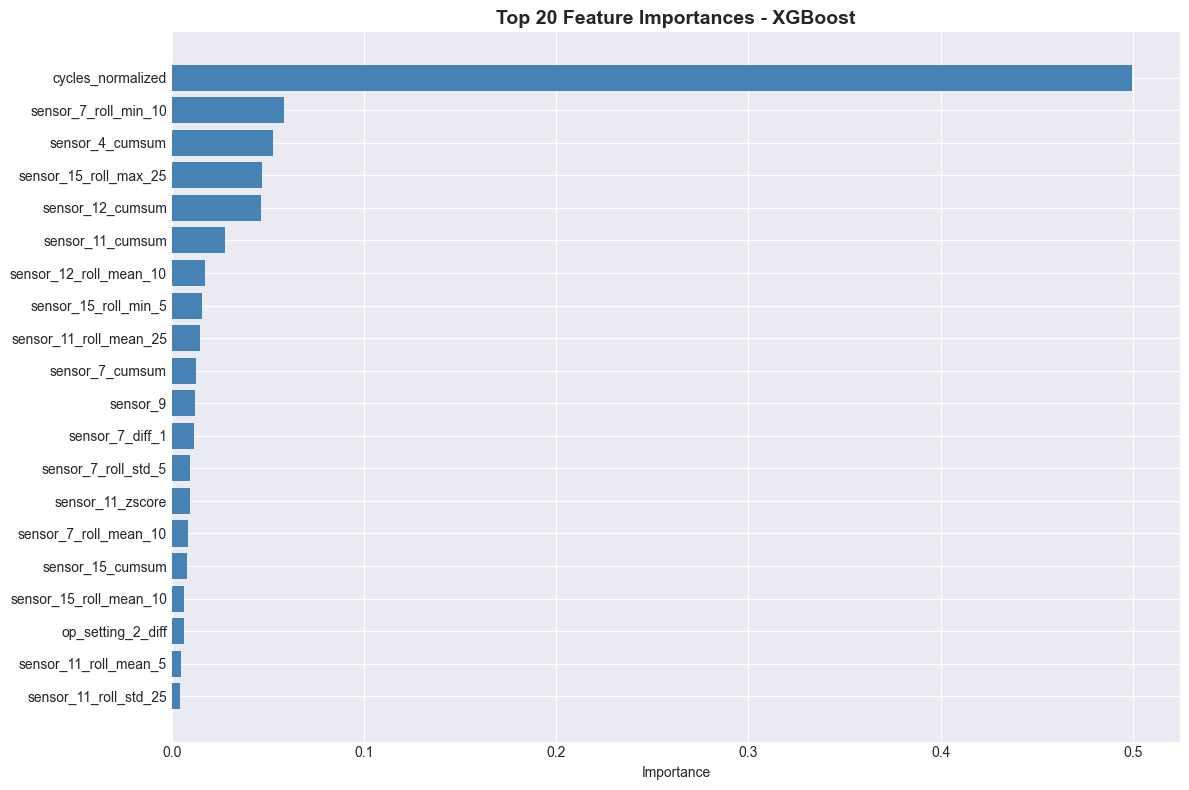

In [11]:
# Get feature importances
importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_baseline.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importances.head(20))

# Plot top 20
plt.figure(figsize=(12, 8))
top_20 = importances.head(20)
plt.barh(range(len(top_20)), top_20['importance'], color='steelblue')
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - XGBoost', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 9. Hyperparameter Tuning with Optuna

In [12]:
# Setup MLflow - use local file-based tracking
mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("turbofan_xgboost_baseline")

print("🔬 Starting Optuna hyperparameter optimization...")
print("   This may take 10-15 minutes on CPU\n")

def objective(trial):
    """
    Optuna objective function for XGBoost hyperparameter tuning.
    Optimizes F2 score (beta=2 emphasizes recall).
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'tree_method': 'hist',
        'eval_metric': 'logloss'
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train_balanced, 
        y_train_balanced,
        eval_set=[(X_val_scaled, y_val)],
        verbose=False
    )
    
    y_pred = model.predict(X_val_scaled)
    f2 = fbeta_score(y_val, y_pred, beta=2)
    
    return f2

# Run optimization
study = optuna.create_study(direction='maximize', study_name='xgboost_f2_optimization')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"\n✅ Optimization complete!")
print(f"\nBest F2 Score: {study.best_value:.4f}")
print(f"\nBest Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2026-02-07 19:52:00,673] A new study created in memory with name: xgboost_f2_optimization


🔬 Starting Optuna hyperparameter optimization...
   This may take 10-15 minutes on CPU



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-07 19:52:01,923] Trial 0 finished with value: 0.9957081545064378 and parameters: {'n_estimators': 283, 'max_depth': 9, 'learning_rate': 0.08279912499386087, 'subsample': 0.7359821405221426, 'colsample_bytree': 0.9775349596925852, 'min_child_weight': 9, 'gamma': 0.2901462985032969, 'reg_alpha': 0.6277245978560727, 'reg_lambda': 0.6946250971865107}. Best is trial 0 with value: 0.9957081545064378.
[I 2026-02-07 19:52:02,927] Trial 1 finished with value: 0.9872068230277186 and parameters: {'n_estimators': 154, 'max_depth': 9, 'learning_rate': 0.013807932428049396, 'subsample': 0.6432973491138004, 'colsample_bytree': 0.6883294370176744, 'min_child_weight': 9, 'gamma': 0.25838845426094725, 'reg_alpha': 0.09306372218563619, 'reg_lambda': 0.23501017643588473}. Best is trial 0 with value: 0.9957081545064378.
[I 2026-02-07 19:52:04,006] Trial 2 finished with value: 0.9957173447537473 and parameters: {'n_estimators': 205, 'max_depth': 7, 'learning_rate': 0.034364830295889895, 'subsampl

## 10. Train Final Model with Best Parameters

In [13]:
# Train final model with best hyperparameters
print("Training final optimized model...")

best_params = study.best_params.copy()
best_params.update({
    'random_state': 42,
    'tree_method': 'hist',
    'eval_metric': 'logloss'
})

xgb_final = xgb.XGBClassifier(**best_params)
xgb_final.fit(
    X_train_balanced,
    y_train_balanced,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False
)

print("✅ Final model trained")

Training final optimized model...
✅ Final model trained


## 11. Final Model Evaluation

In [14]:
# Evaluate on validation set
y_val_pred_final = xgb_final.predict(X_val_scaled)
y_val_proba_final = xgb_final.predict_proba(X_val_scaled)[:, 1]

f2_val = fbeta_score(y_val, y_val_pred_final, beta=2)
precision_val = precision_score(y_val, y_val_pred_final)
recall_val = recall_score(y_val, y_val_pred_final)
roc_auc_val = roc_auc_score(y_val, y_val_proba_final)

print("="*60)
print("FINAL MODEL PERFORMANCE (Validation Set)")
print("="*60)
print(f"\nF2 Score:   {f2_val:.4f} {'✅' if f2_val > 0.75 else '❌ (Target: >0.75)'}")
print(f"Precision:  {precision_val:.4f} {'✅' if precision_val > 0.65 else '❌ (Target: >0.65)'}")
print(f"Recall:     {recall_val:.4f} {'✅' if recall_val > 0.85 else '❌ (Target: >0.85)'}")
print(f"ROC-AUC:    {roc_auc_val:.4f}")

print(f"\n{classification_report(y_val, y_val_pred_final, target_names=['Normal', 'Failure Soon'])}")

FINAL MODEL PERFORMANCE (Validation Set)

F2 Score:   0.9983 ✅
Precision:  0.9915 ✅
Recall:     1.0000 ✅
ROC-AUC:    1.0000

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      2745
Failure Soon       0.99      1.00      1.00       465

    accuracy                           1.00      3210
   macro avg       1.00      1.00      1.00      3210
weighted avg       1.00      1.00      1.00      3210



In [15]:
# Evaluate on test set (final held-out data)
y_test_pred = xgb_final.predict(X_test_scaled)
y_test_proba = xgb_final.predict_proba(X_test_scaled)[:, 1]

f2_test = fbeta_score(y_test, y_test_pred, beta=2)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_proba)

print("="*60)
print("FINAL MODEL PERFORMANCE (Test Set - Held Out)")
print("="*60)
print(f"\nF2 Score:   {f2_test:.4f} {'✅' if f2_test > 0.75 else '❌ (Target: >0.75)'}")
print(f"Precision:  {precision_test:.4f} {'✅' if precision_test > 0.65 else '❌ (Target: >0.65)'}")
print(f"Recall:     {recall_test:.4f} {'✅' if recall_test > 0.85 else '❌ (Target: >0.85)'}")
print(f"ROC-AUC:    {roc_auc_test:.4f}")

print(f"\n{classification_report(y_test, y_test_pred, target_names=['Normal', 'Failure Soon'])}")

FINAL MODEL PERFORMANCE (Test Set - Held Out)

F2 Score:   0.9923 ✅
Precision:  0.9707 ✅
Recall:     0.9978 ✅
ROC-AUC:    0.9999

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      2826
Failure Soon       0.97      1.00      0.98       465

    accuracy                           1.00      3291
   macro avg       0.99      1.00      0.99      3291
weighted avg       1.00      1.00      1.00      3291



## 12. ROC Curve & Precision-Recall Curve

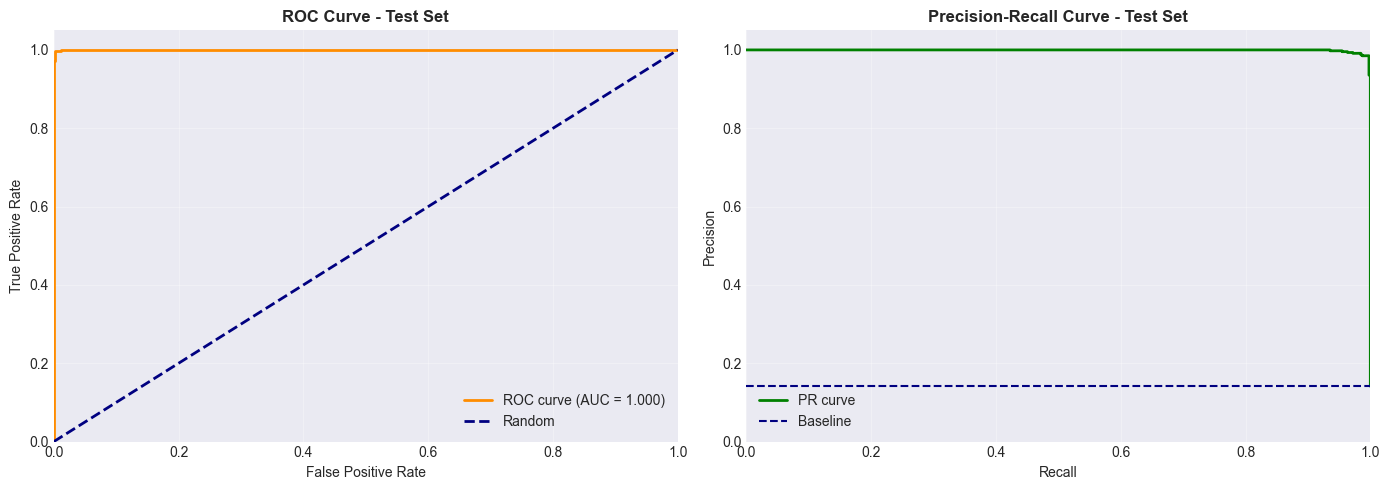

In [16]:
# Plot ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_test:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - Test Set', fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_test_proba)
axes[1].plot(recall_curve, precision_curve, color='green', lw=2, label=f'PR curve')
axes[1].axhline(y=(y_test == 1).sum() / len(y_test), color='navy', linestyle='--', label='Baseline')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve - Test Set', fontweight='bold')
axes[1].legend(loc='lower left')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Log to MLflow

In [17]:
# Log final model to MLflow
with mlflow.start_run(run_name="xgboost_optimized_final"):
    # Log parameters
    mlflow.log_params(best_params)
    
    # Log metrics (validation)
    mlflow.log_metric("val_f2_score", f2_val)
    mlflow.log_metric("val_precision", precision_val)
    mlflow.log_metric("val_recall", recall_val)
    mlflow.log_metric("val_roc_auc", roc_auc_val)
    
    # Log metrics (test)
    mlflow.log_metric("test_f2_score", f2_test)
    mlflow.log_metric("test_precision", precision_test)
    mlflow.log_metric("test_recall", recall_test)
    mlflow.log_metric("test_roc_auc", roc_auc_test)
    
    # Log model
    mlflow.xgboost.log_model(xgb_final, "model")
    
    # Log dataset info
    mlflow.log_param("train_samples", len(X_train_balanced))
    mlflow.log_param("val_samples", len(X_val))
    mlflow.log_param("test_samples", len(X_test))
    mlflow.log_param("num_features", len(feature_cols))
    
    print("✅ Model and metrics logged to MLflow")
    print(f"   Run ID: {mlflow.active_run().info.run_id}")

✅ Model and metrics logged to MLflow
   Run ID: bbb8b81aa627421eb7e92cb5d5c65573


## 14. Save Model & Artifacts

In [18]:
# Save model
model_path = Path('../data/models/xgboost_baseline.json')
model_path.parent.mkdir(exist_ok=True)
xgb_final.save_model(model_path)
print(f"✅ Model saved to: {model_path}")

# Save scaler
import joblib
scaler_path = Path('../data/models/scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler saved to: {scaler_path}")

# Save feature names
feature_names_path = Path('../data/models/feature_names.json')
with open(feature_names_path, 'w') as f:
    json.dump({'features': feature_cols}, f, indent=2)
print(f"✅ Feature names saved to: {feature_names_path}")

# Save model metrics
metrics = {
    'model': 'XGBoost Baseline',
    'timestamp': pd.Timestamp.now().isoformat(),
    'validation_metrics': {
        'f2_score': float(f2_val),
        'precision': float(precision_val),
        'recall': float(recall_val),
        'roc_auc': float(roc_auc_val)
    },
    'test_metrics': {
        'f2_score': float(f2_test),
        'precision': float(precision_test),
        'recall': float(recall_test),
        'roc_auc': float(roc_auc_test)
    },
    'hyperparameters': best_params,
    'dataset_info': {
        'train_samples': len(X_train_balanced),
        'val_samples': len(X_val),
        'test_samples': len(X_test),
        'num_features': len(feature_cols)
    }
}

metrics_path = Path('../data/models/xgboost_baseline_metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)
print(f"✅ Metrics saved to: {metrics_path}")

✅ Model saved to: ..\data\models\xgboost_baseline.json
✅ Scaler saved to: ..\data\models\scaler.pkl
✅ Feature names saved to: ..\data\models\feature_names.json
✅ Metrics saved to: ..\data\models\xgboost_baseline_metrics.json
